# **CS482 Final Project**
### **Written by:** Diane Hamilton and Aadya Kamath
### **Due:** May 13, 2025

## **Topic:** FungiCLEF25 @ CVPR-FGVC & LifeCLEF

##**Overview**
The FungiCLEF Challenge focuses on few-shot recognition of fungi species using real-world observational data. Each observation includes multiple photographs of the same specimen, along with metadata (e.g., location, timestamp, substrate, habitat, toxicity), satellite imagery and meteorological variables.
<p>
The goal of the challenge is to develop a classification model capable of returning a ranked list of predicted species for each observation. A key challenge lies in handling a large number of species consisted of rare and under-recorded taxa with very few training examples.

**Input:** A list of fungi observations.
**Output:** A list of Top-k predicted fungi species from a predefined set of classes.

**Kagle Link**: https://www.kaggle.com/competitions/fungi-clef-2025


# 🔬 **0: Setup Steps**

In this section, we carry out installations that are necessary for performing the tasks we will be performing in this project.

##**📌 Tools to keep in mind**

PyTorch or TensorFlow for modeling

Hugging Face transformers for text

sklearn/pandas for tabular preprocessing

albumentations or timm for data augmentation

Faiss for embedding similarity search (rare species)

In [1]:
#pip install our desired model
#pip install other packages or libraries we need

import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from constants import *
import load_data

##🤔**1: Understand the Problem**

**Goal:** Rank fungi species per observation (i.e., not just top-1 accuracy).

**Challenge:** Many classes (2,000+), most with very few examples (1–4).

**Opportunity:** Rich metadata (temporal, spatial, environmental) and image captions to augment vision data.

Azure Blob Storage Python quickstart sample


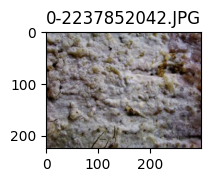

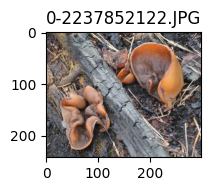

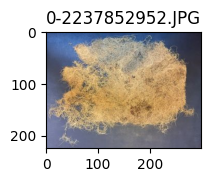

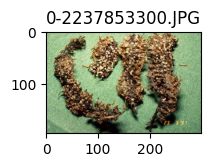

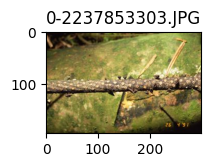

In [ ]:
# visualize img data
load_data.preview_data()

In [3]:
# and tabular data
train_metadata = load_data.csv_data("train")
test_metadata = load_data.csv_data("test")
val_metadata = load_data.csv_data("val")

In [4]:
train_metadata

,eventDate,year,month,day,habitat,countryCode,scientificName,kingdom,phylum,class,...,observationID,region,district,filename,category_id,metaSubstrate,poisonous,elevation,landcover,biogeographicalRegion
0,2021-01-24,2021,1.0,24.0,Mixed woodland (with coniferous and deciduous ...,DK,Xylohypha ferruginosa (Corda) S.Hughes,Fungi,Ascomycota,Eurotiomycetes,...,3052832307,Sjælland,Næstved,0-3052832307.JPG,2421,wood,0,0.0,16.0,continental
1,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,3061954303,Hovedstaden,Gribskov,0-3061954303.JPG,386,wood,0,0.0,17.0,continental
2,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,3061954303,Hovedstaden,Gribskov,1-3061954303.JPG,386,wood,0,0.0,17.0,continental
3,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,3061954303,Hovedstaden,Gribskov,2-3061954303.JPG,386,wood,0,0.0,17.0,continental
4,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,3061954303,Hovedstaden,Gribskov,3-3061954303.JPG,386,wood,0,0.0,17.0,continental
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7814,2021-12-18,2021,12.0,18.0,Deciduous woodland,DK,Plagiosphaera immersa (Trail) Petr.,Fungi,Ascomycota,Sordariomycetes,...,4100093368,Hovedstaden,Rudersdal,0-4100093368.JPG,1736,plant material,0,93.0,1.0,continental
7815,2021-12-18,2021,12.0,18.0,Deciduous woodland,DK,Plagiosphaera immersa (Trail) Petr.,Fungi,Ascomycota,Sordariomycetes,...,4100093368,Hovedstaden,Rudersdal,2-4100093368.JPG,1736,plant material,0,93.0,1.0,continental
7816,2021-12-30,2021,12.0,30.0,Unmanaged deciduous woodland,DK,Mycobernardia incrustans (Parmasto) Ghobad-Nejhad,Fungi,Basidiomycota,Agaricomycetes,...,3429079314,Sjælland,Sorø,2-3429079314.JPG,1465,wood,0,0.0,17.0,continental
7817,2015-06-28,2015,6.0,28.0,salt meadow,DK,Laboulbenia curtipes Thaxt.,Fungi,Ascomycota,Laboulbeniomycetes,...,4847339663,NaN,NaN,0-4847339663.JPG,1166,animals,0,0.0,17.0,continental


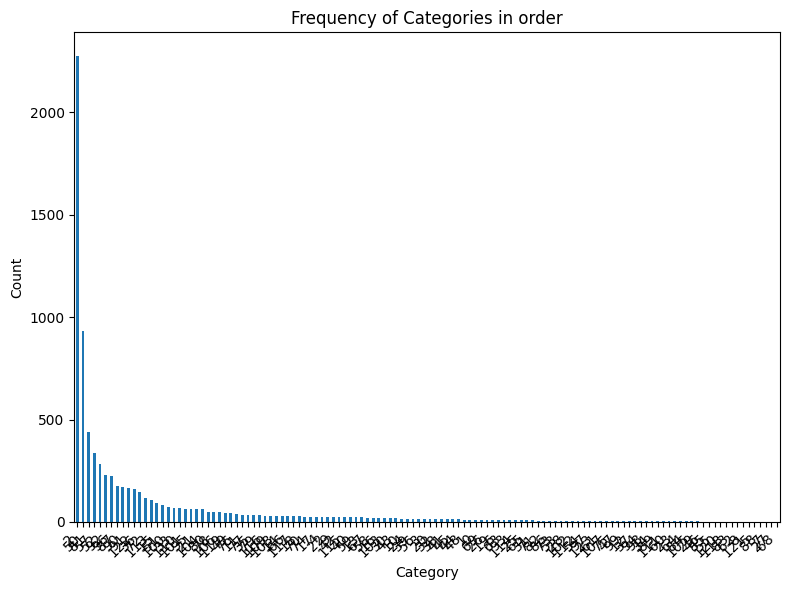

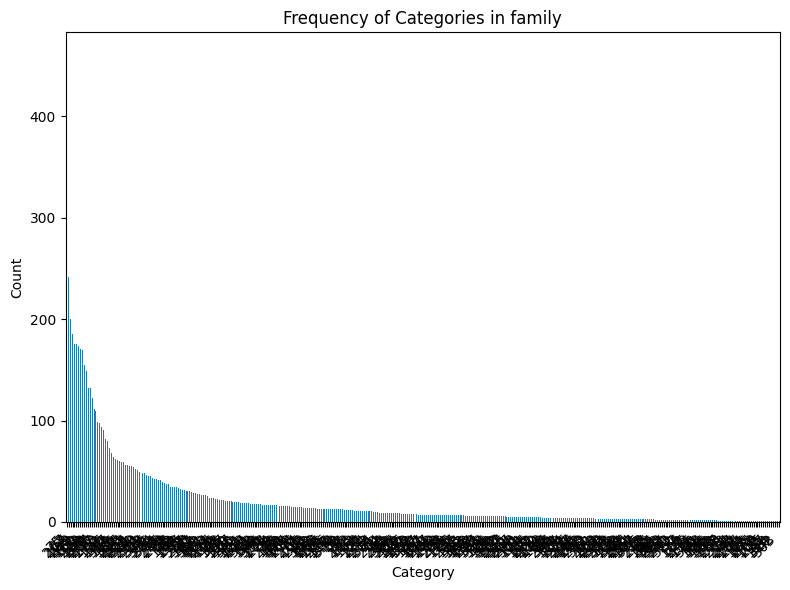

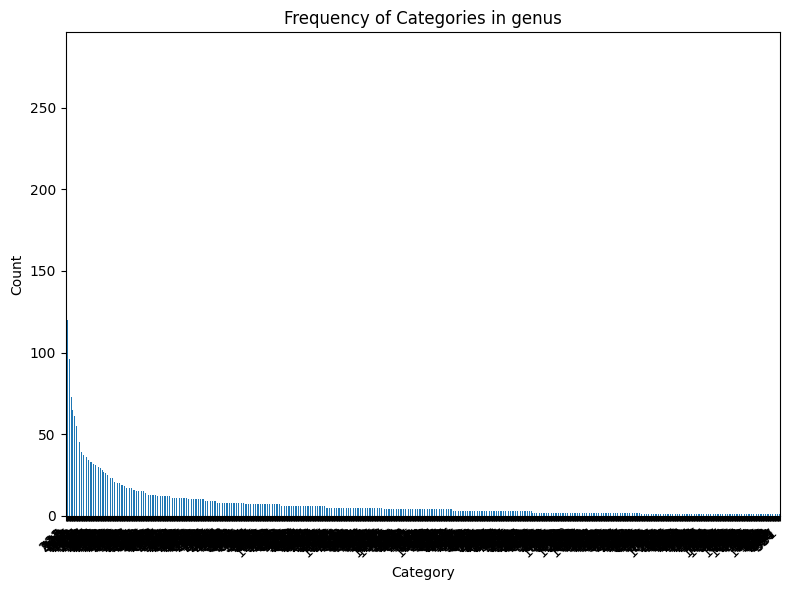

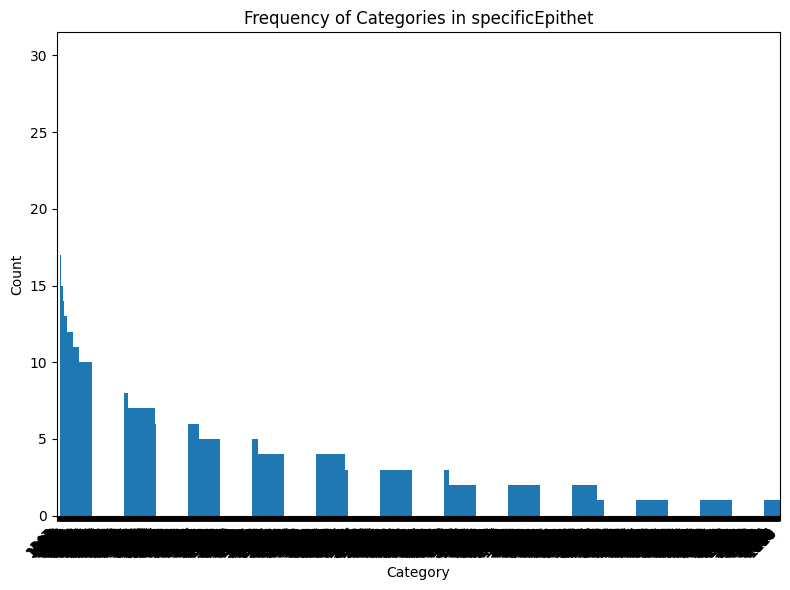

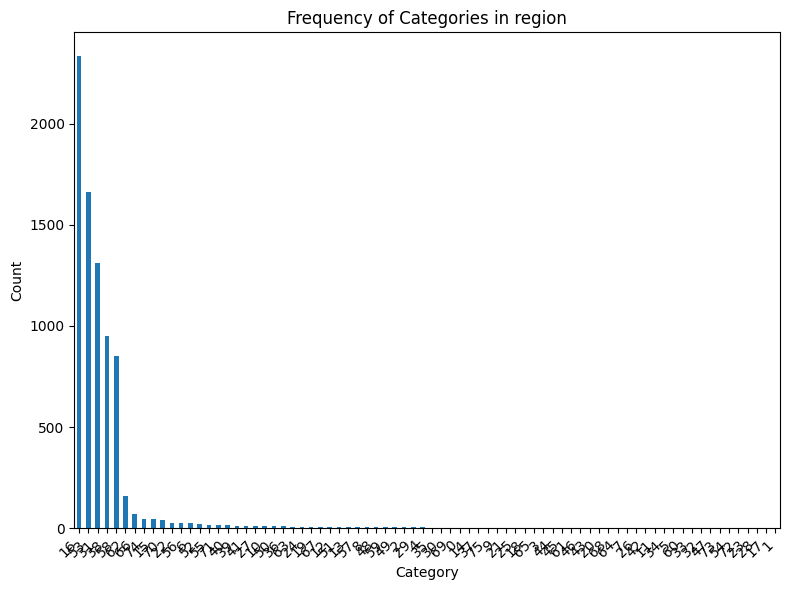

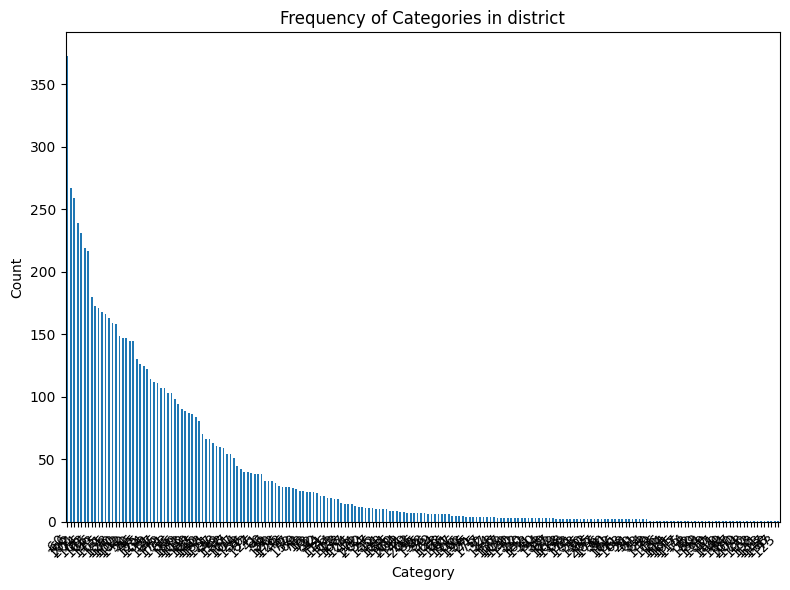

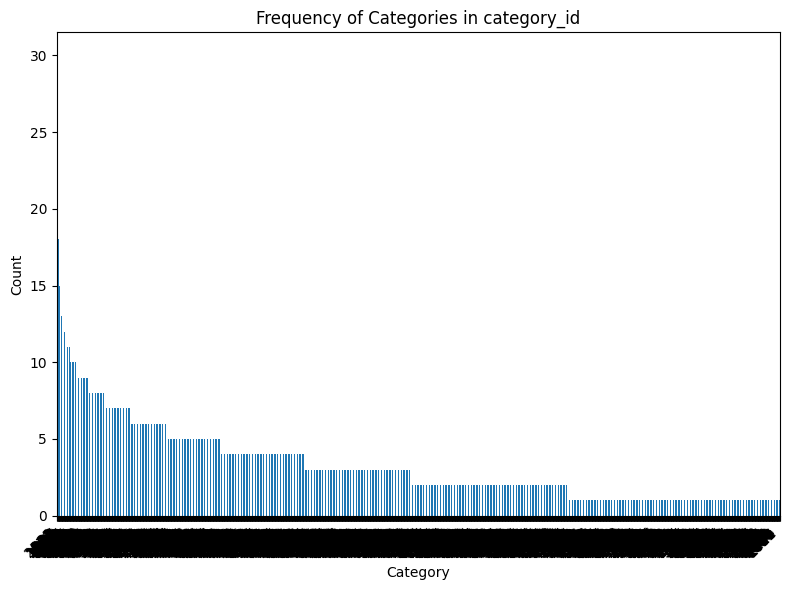

In [5]:
# identify if data is skewed
load_data.visualize_categories('train')

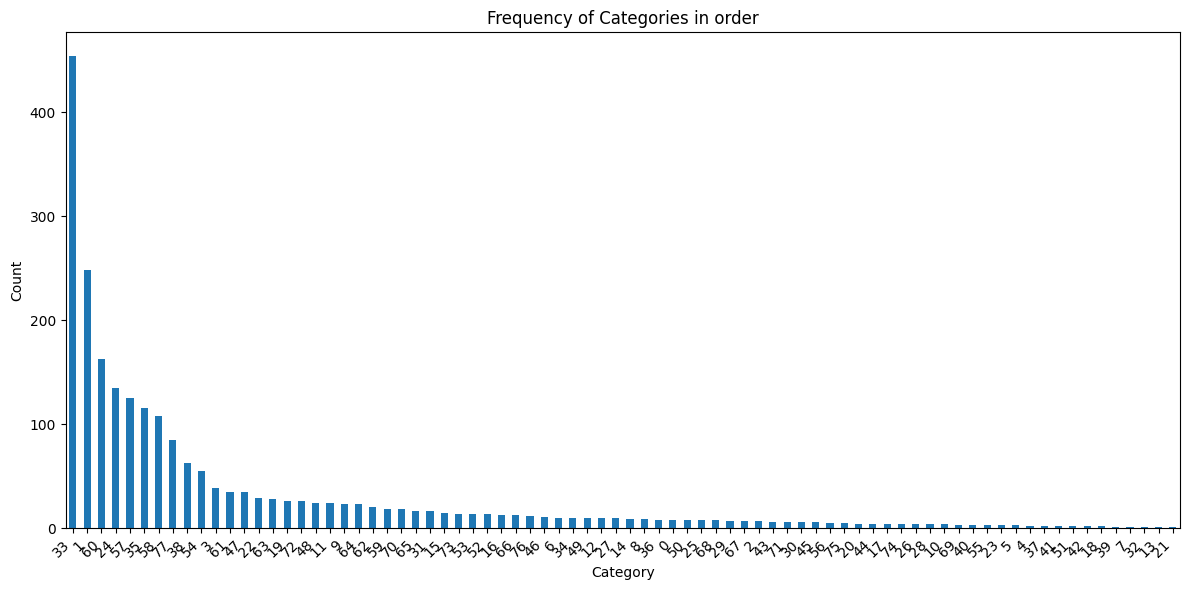

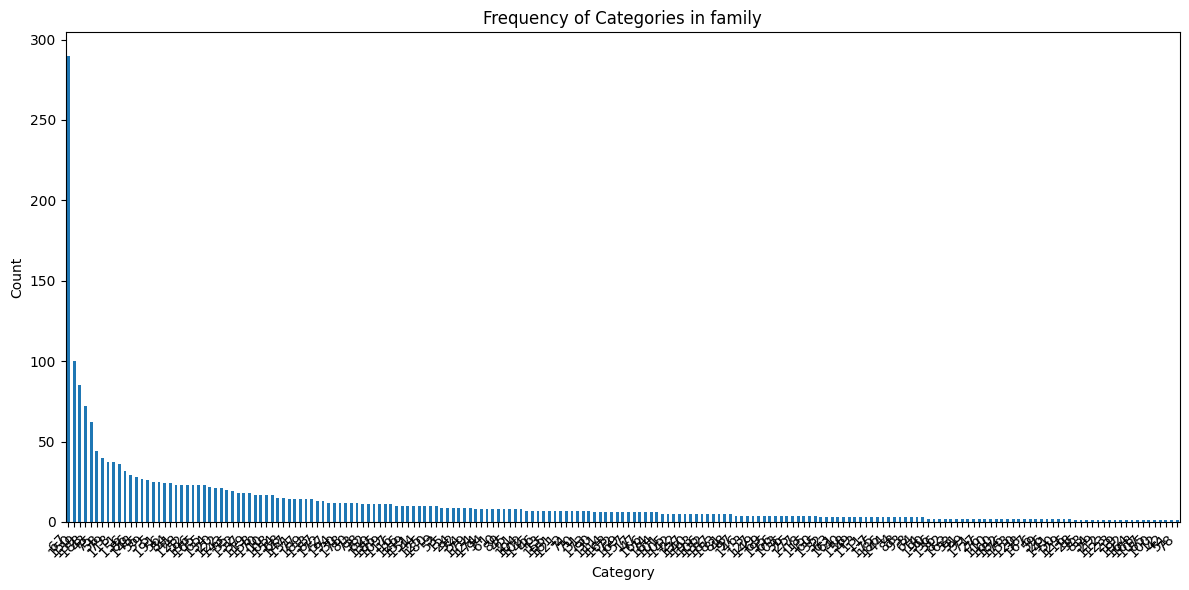

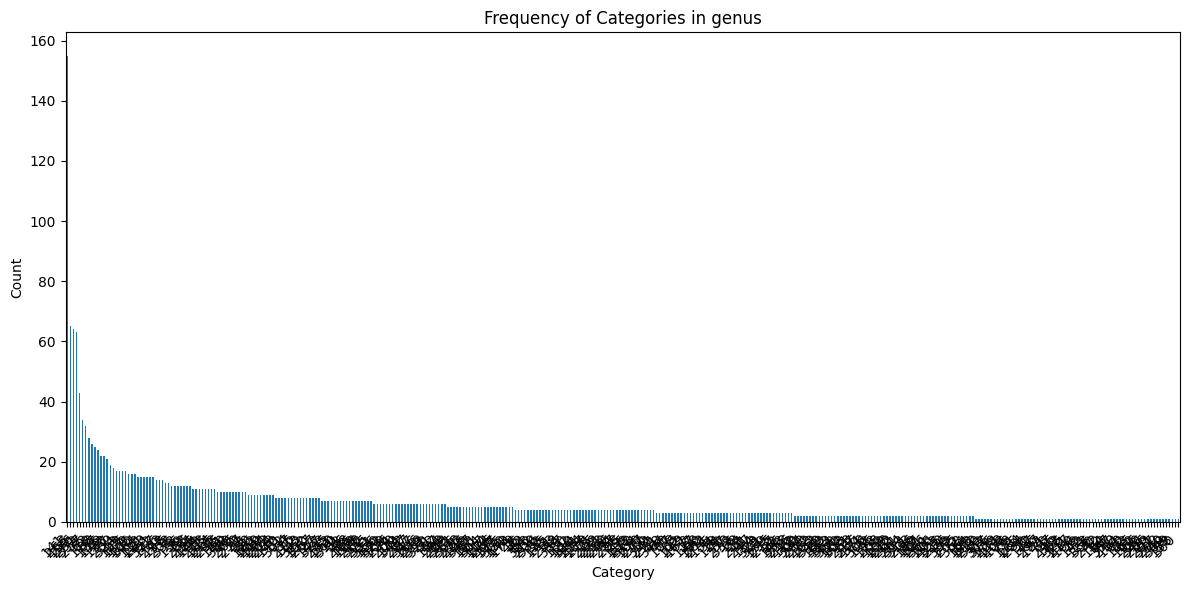

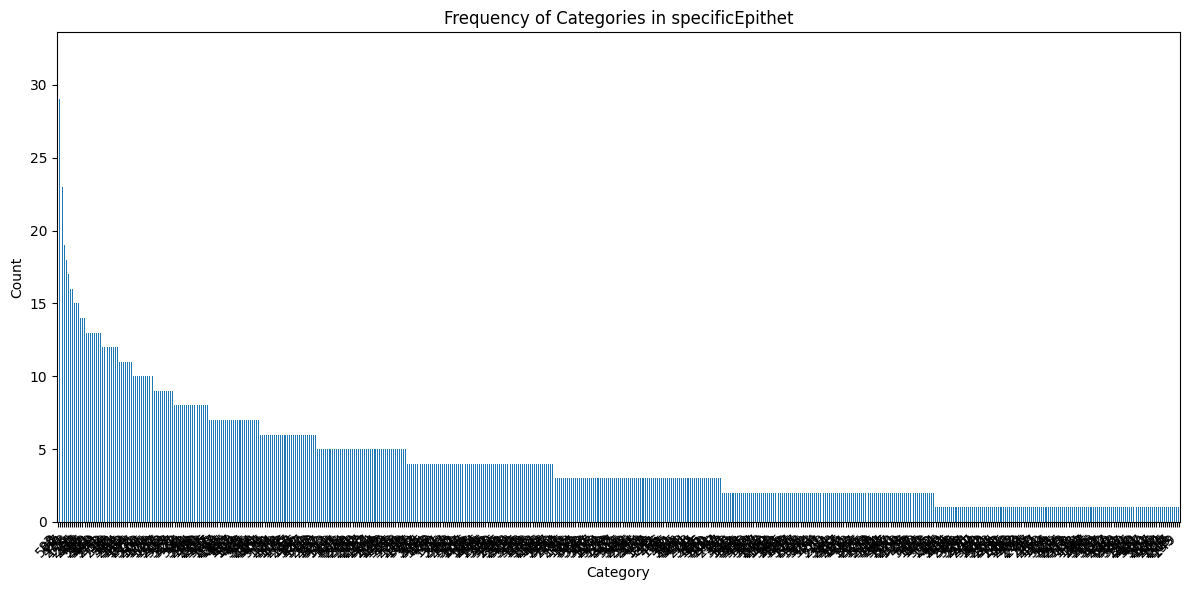

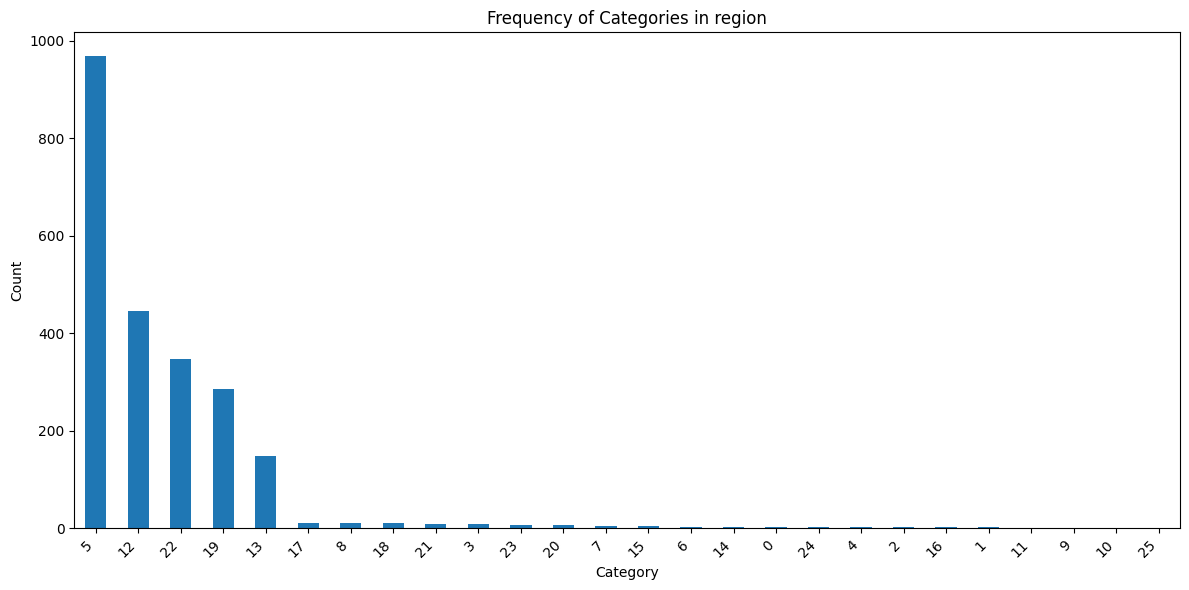

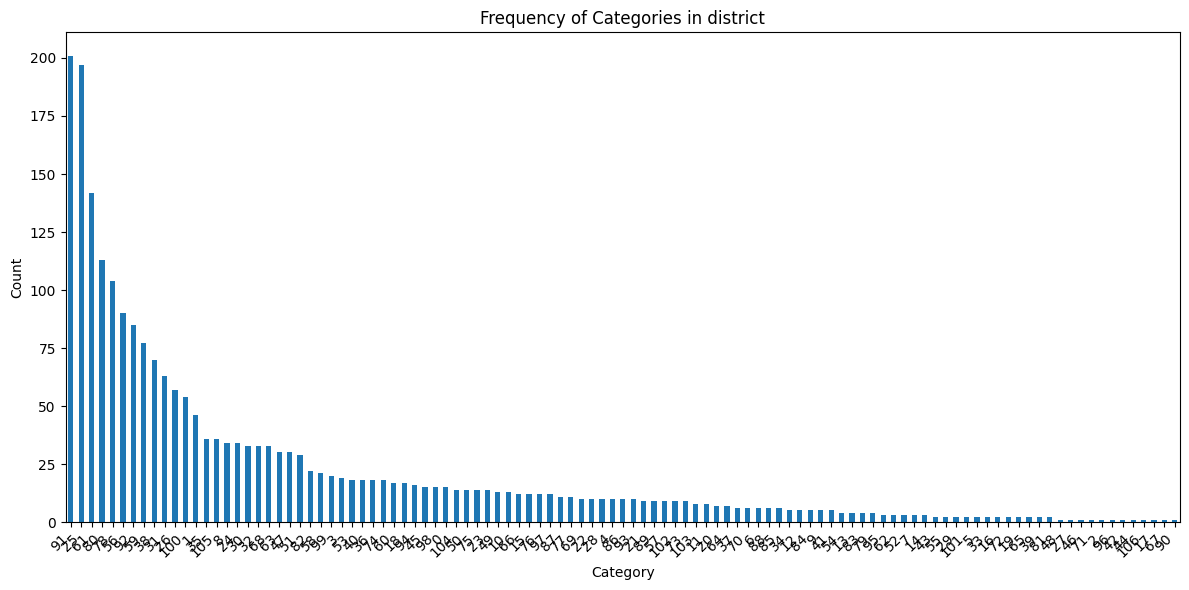

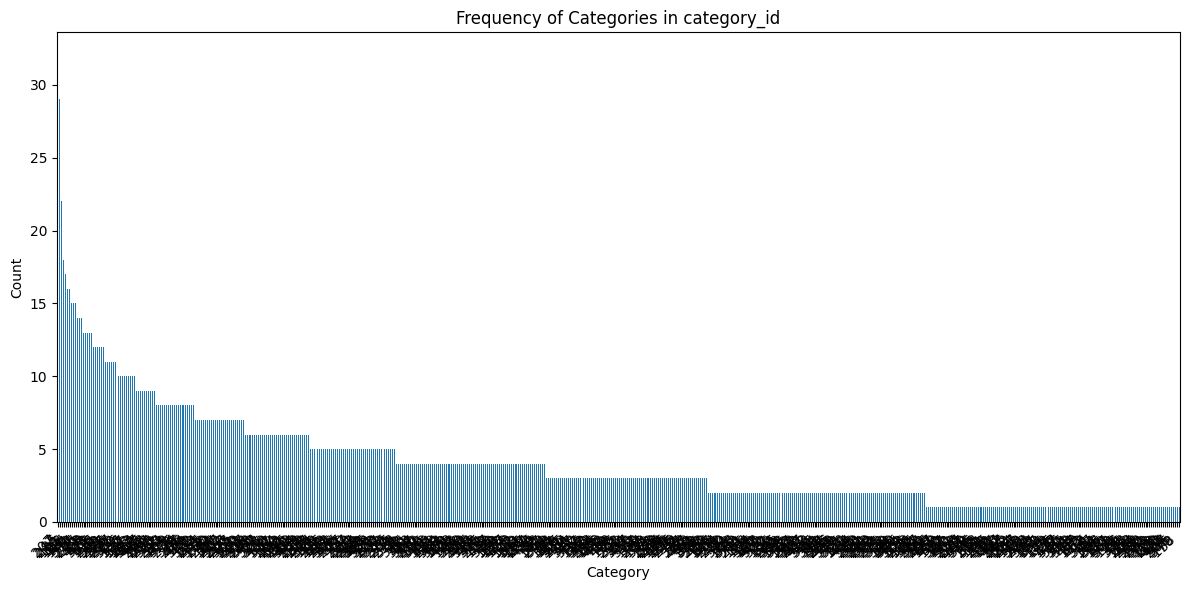

In [7]:
# identify if data is skewed
load_data.visualize_categories('val')

In [ ]:
# download data potentially
# train_metadata.to_csv('train_metadata.csv')
# test_metadata.to_csv('test_metadata.csv')
# val_metadata.to_csv('val_metadata.csv')

##⛽**2: Preprocess & Explore the Data**

**Image sets:** Start with 300px or 500px images for quicker experimentation.

**Metadata:** Normalize categorical fields (habitat, substrate), encode timestamps (month/day), and parse EXIF features.

**Satellite images & captions:** Treat these as separate input modalities for later fusion.

**Class imbalance:** Compute class frequencies and identify rare classes.

In [ ]:
# perform preprocessing on img data

In [6]:
# perform preprocessing on tabular data
train_metadata = load_data.standardize_data(train_metadata)
test_metadata = load_data.standardize_data(test_metadata)
val_metadata = load_data.standardize_data(val_metadata)

In [7]:
train_metadata

,eventDate,order,family,genus,specificEpithet,latitude,longitude,coorUncert,region,district,...,poisonous_0,poisonous_1,biogeographicalRegion_UNK,biogeographicalRegion_alpine,biogeographicalRegion_arctic,biogeographicalRegion_atlantic,biogeographicalRegion_boreal,biogeographicalRegion_continental,biogeographicalRegion_macaronesia,biogeographicalRegion_mediterranean
0,2021-01-24,26,348,1010,712,55.227983,11.680016,-0.069474,53,125,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2021-02-27,101,314,207,74,56.087201,12.215145,-0.088936,16,60,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2021-02-27,101,314,207,74,56.087201,12.215145,-0.088936,16,60,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2021-02-27,101,314,207,74,56.087201,12.215145,-0.088936,16,60,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2021-02-27,101,314,207,74,56.087201,12.215145,-0.088936,16,60,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7814,2021-12-18,100,348,718,950,55.815643,12.521222,-0.069474,16,143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7815,2021-12-18,100,348,718,950,55.815643,12.521222,-0.069474,16,143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7816,2021-12-30,32,74,591,960,55.378062,11.551180,-0.037038,53,156,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7817,2015-06-28,56,164,457,526,54.977367,9.752582,-0.004601,66,179,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
test_metadata

,eventDate,latitude,longitude,coorUncert,region,district,filename,elevation,landcover,habitat_Acidic oak woodland,...,metaSubstrate_plant material,metaSubstrate_stone,metaSubstrate_wood,biogeographicalRegion_UNK,biogeographicalRegion_alpine,biogeographicalRegion_arctic,biogeographicalRegion_atlantic,biogeographicalRegion_boreal,biogeographicalRegion_continental,biogeographicalRegion_mediterranean
0,2023-01-08,55.993269,12.290225,0.053616,5,34,0-4100099350.JPG,-0.305172,0.491271,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2023-01-10,55.973423,10.550840,-0.182904,9,76,1-4100096393.JPG,-0.170720,0.491271,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2023-01-09,28.501376,-17.874959,-0.182904,6,77,0-4100103428.JPG,-0.580480,-2.234550,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-01-09,28.501376,-17.874959,-0.182904,6,77,1-4100103428.JPG,-0.580480,-2.234550,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-01-09,28.501376,-17.874959,-0.182904,6,77,2-4100103428.JPG,-0.580480,-2.234550,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906,2023-11-17,37.523163,-4.327254,-0.083040,1,12,0-4465903708.JPG,4.599139,0.491271,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1907,2023-11-11,55.570755,8.299528,-0.182904,20,14,0-4465903714.JPG,-0.535662,-0.190185,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1908,2023-11-20,55.973126,11.778573,0.185016,18,67,1-4465903823.JPG,-0.426820,-2.007398,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1909,2023-11-20,55.973126,11.778573,0.185016,18,67,3-4465903823.JPG,-0.426820,-2.007398,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
val_metadata

,eventDate,order,family,genus,specificEpithet,latitude,longitude,coorUncert,region,district,...,metaSubstrate_stone,metaSubstrate_wood,poisonous_0,poisonous_1,biogeographicalRegion_UNK,biogeographicalRegion_alpine,biogeographicalRegion_atlantic,biogeographicalRegion_boreal,biogeographicalRegion_continental,biogeographicalRegion_mediterranean
0,2022-01-21,58,143,308,195,55.758479,12.507390,-0.014307,5,25,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2022-01-21,58,143,308,195,55.758479,12.507390,-0.014307,5,25,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2022-01-21,58,143,308,195,55.758479,12.507390,-0.014307,5,25,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2022-01-21,58,143,308,195,55.758479,12.507390,-0.014307,5,25,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2022-01-24,58,143,308,195,55.590268,12.302532,-0.286430,19,30,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,2022-12-23,33,114,209,417,56.166248,10.686894,-0.014307,12,92,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2281,2022-12-23,33,114,209,417,56.166248,10.686894,-0.014307,12,92,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2282,2022-07-21,54,10,27,60,71.730089,-53.987366,-0.286430,18,99,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2283,2022-07-21,54,10,27,60,71.730089,-53.987366,-0.286430,18,99,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# (optional) encode metadata

##**3: Base Modeling**

**Image model:** Use a pre-trained image encoder (e.g. EfficientNet, ConvNeXt, or a ViT variant) fine-tuned on your dataset.

**Metadata model:** MLP over tabular features (or transformer if complex). Normalize numerical fields.

**Combine:** Late fusion — combine image and metadata logits before ranking predictions.

**Loss:** Use cross-entropy with class re-weighting or focal loss to boost rare class signal.

In [ ]:
# base model

##**4: Improve Recall@5 (Core Metric)**

**Multi-label softmax + top-k selection:** Ensure your model predicts scores for all classes, then evaluate Top-5 accuracy.

**Labelling:** Apply label smoothing or mixup to improve generalization.

**Classification:** Use cosine classifier or ArcFace for better separation in embedding space.

In [ ]:
# improve recall

##**5: Handling Rare Classes**

**Data augmentation:** Use strong augmentations (RandAugment, CutMix, etc.).

**External data:** Use semi-supervised learning (e.g., pseudo-labeling) if allowed by rules.

***Use class prototypes or nearest neighbor matching from image embeddings to help model similarity across species.*

In [ ]:
# rare cases

##**6: Captions & Satellite Data**

**Captions:** Encode using a text transformer (e.g., BERT or CLIP text encoder) and fuse with image features.

**Satellite data:** Use a small CNN or ViT variant to extract environmental embeddings.

**Fusion:** Concatenate embeddings (early fusion) or fuse logits (late fusion). Try attention-based fusion for best performance.

##**7: Train & Validate**

**Stratified sampling for cross-validation:** Ensure rare classes are seen.

**Train:** Train with multi-task loss (e.g., predict both species and toxicity) for auxiliary signal.

**Recall@5:** Evaluate with Recall@5 consistently — this is your main optimization target.



##**8: Submission Pipeline**

For each observation:

Aggregate predictions across multiple images.

Return top-5 ranked species labels.

Format correctly using the sample submission file.